# The secret of happiness

## 1. Introduction
There are a lot factors that affect directly or indirectly on the general happiness of a country. Being such a subjective matter, knowing exactly what factors are the ones that affect the most on the happiness of a population is a challenge.

In this article we will try to find the relationship between some socioeconomic indicators with the happiness score of each country.
To do this problem we will be using 2 different datasets extracted from Kaggle: [World Development Indicators](https://www.kaggle.com/worldbank/world-development-indicators) and [World Happiness Report](https://www.kaggle.com/unsdsn/world-happiness). World Development Indicators contains the economic development indicators from the World Bank. There is a great variety of indicators, such as the GDP per capita, the number of Internet users, the infant mortality rate, etcetera.

On the other hand, the World Happiness Report contains information about a Happiness Score of each country. This Happiness Score has been computed using the answers from a statistically representative survey.

From the dataset World Development Indicators we will extract values from economic and social indicators, and from World Happiness Report we will extract the Happiness Score of each country. In conclusion, if we fusionate the data from both of the datasets, we will be able to find the relationship between the indicators and the happiness score.

As an outline for this article, the following topics will be covered:
* Data cleaning and preparation
* Union of two datasets
* Data analysis plotting information on a world map
* Creation of a Regression model to predict the Happiness Score
* Evaluation of a Regression model

The dependencies in this problem are:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

## 2. Data cleaning and preparation

The first step for this problem is reading and preparing the two datasets that we will be using. From the dataset World Development Indicators we need only the names of the countries, the indicators IDs and the values of the indicators. On the other hand, from the dataset World Happiness Report we will only get the names of the countries and the happiness score of each one. We will get the name of the countries from the 2 datasets because it will be the parameter by which we will join the two datasets.

### 2.1. World Development Indicators

First, let’s read the dataset:

In [2]:
# 1. Reading the World Development Indicators dataset
wi_path = "Indicators.csv"
wi_data = pd.read_csv(wi_path)

This dataset contains a vast quantity of indicators, but we have selected the few ones that can give us a global vision of some characteristics of a country:

* **GDP per capita**: this indicator is a measure of a country’s economic output that accounts for its number of people. It is obtained dividing the gross domestic product by the total population of a country. In conclusion, this indicator can tell how prosperous a country feels to each of its citizens.
* **Infant mortality rate (per 1,000 live births)**: this is the number of children that dies of every 1,000 live births. This indicator reflects the wealth, the technological development and the medical advances of a country.
* **Internet Users (of every 100 people)**: this indicator says the number of people that has access to Internet in a daily basis. This can reflect the level of technological development that the population have.
* **Mobile phone subscriptions (of every 100 people)**: very similar as the previous indicator, but in this case showing the number of mobile phone subscriptions. This indicator can also show the level of technological development of the population.

To clean the dataset, we will get the rows containing the indicators we are interested in and we will delete the NaN values:

In [3]:
# We only want some columns and rows of the dataset
wi_data = wi_data[['CountryName','IndicatorCode','Year','Value']]
wi_data = wi_data[wi_data['Year'] == 2013]

# We only want data of some specific indicators
indicators = ["NY.GDP.PCAP.CD","SP.DYN.IMRT.IN", "IT.CEL.SETS.P2", "IT.NET.USER.P2"]

wi_data = wi_data[wi_data['IndicatorCode'].isin(indicators)]
wi_data = wi_data.pivot_table(index=['CountryName'], columns=['IndicatorCode'], values=['Value']).reset_index()

column_names = ["Country Name", "Mobile phone subscriptions", "Internet Users", "GDP per capita",
                "Infant mortality rate"]
wi_data.columns = column_names

print(wi_data.head())

  Country Name  Mobile phone subscriptions  Internet Users  GDP per capita  \
0  Afghanistan                   70.661359             5.9      666.795051   
1      Albania                  116.157208            57.2     4411.258241   
2      Algeria                  100.787721            16.5     5491.614414   
3      Andorra                   80.702618            94.0    42806.522553   
4       Angola                   61.873297            19.1     5900.529570   

   Infant mortality rate  
0                   69.9  
1                   13.3  
2                   22.1  
3                    2.2  
4                  101.4  


### 2.2. World Happiness Report

We will follow the same process of reading and cleaning with this dataset:

In [4]:
# 2. Reading the World Happiness Report dataset
wh_path = "2015.csv"
wh_data = pd.read_csv(wh_path)

# We only want the happiness score of each country
wh_data = wh_data[["Country", "Happiness Score"]]

print(wh_data.head())

       Country  Happiness Score
0  Switzerland            7.587
1      Iceland            7.561
2      Denmark            7.527
3       Norway            7.522
4       Canada            7.427


## 3. Union of the datasets

Now that we have loaded the two datasets, we can join them by the names of the countries. We will also have to change the representation of the table to be able to use it to train a model.

In [5]:
# 3. Union of the dataset
data = pd.merge(wi_data, wh_data, how="left", left_on="Country Name", right_on="Country")

# We clean the data
data = data.dropna()
data = data.reset_index()
data = data.drop(["Country", "index"], axis=1)

print(data.head())

  Country Name  Mobile phone subscriptions  Internet Users  GDP per capita  \
0  Afghanistan                   70.661359             5.9      666.795051   
1      Albania                  116.157208            57.2     4411.258241   
2      Algeria                  100.787721            16.5     5491.614414   
3       Angola                   61.873297            19.1     5900.529570   
4    Argentina                  162.527422            59.9    14443.065651   

   Infant mortality rate  Happiness Score  
0                   69.9            3.575  
1                   13.3            4.959  
2                   22.1            5.605  
3                  101.4            4.033  
4                   11.9            6.574  


## 4. Data Analysis
First of all, we want to discover how mucho correlated are the selected indicators with the happiness score, so we will plot this information in a correlation heatmap.

In [6]:
def correlation_matrix(data):
    plt.figure()
    sns.heatmap(data.corr(), center=0, annot=True, vmin=-1, vmax=1, cmap="RdBu_r")
    plt.savefig("correlations.png")

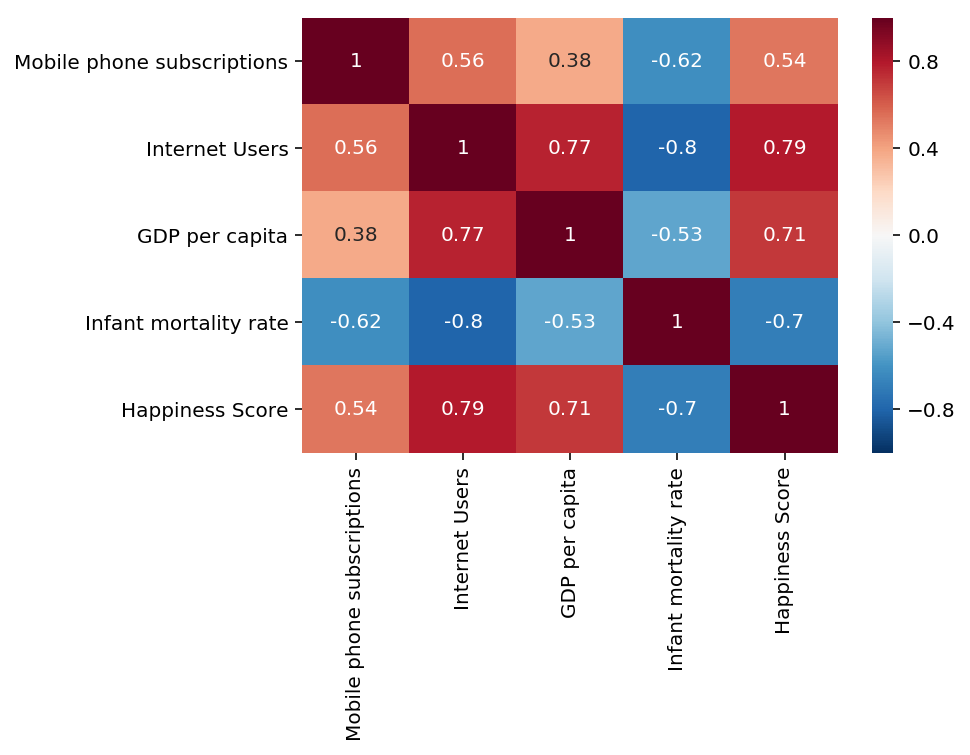

In [7]:
correlation_matrix(data)

This plot is showing some very clear conclusions. The first noticeable fact is that the number of **Internet Users is highly correlated with the happiness score** of the country. The GDP per capita, in turn, is also highly correlated with the number of Internet Users. Knowing these two facts, it's reasonable to confirm that the **technology level of a population is directly related with its wealth**.

Furthermore, the **GDP per capita indicator itself is also very correlated with the level of happiness**, so we can also confirm that the richness of a country is strongly conditioning the happiness of the population.

On the other hand, the indicator **Infant mortality rate is inversely correlated**, in general with all the other indicators, and with the happiness score. It's logic to confirm, then, that the impoverished countries have a higher Infant mortality rate caused by a lower technological development, and this situation is causing a decrease in the happiness of the population.

In this problem we are dealing with data related to economy and some other topics which we are not used to. This is a problem that we will encounter many times when working with data. To help ourselves to understand data from topics that are completely unknown for us, it is important to perform a good analysis of the data. It is a very good practise to create some plots to see the data visually and better understand it.

Just as this data contains information about different countries, the better way to show the information in a more visual way is showing it in a world map. Because of that, we will create an interactive map with the *folium* library to show the indicators that we have selected located by country.

In [8]:
import folium

In [9]:
wi_data = pd.read_csv(wi_path)
indicators = ["IT.NET.USER.P2"]
map_data = wi_data[wi_data['IndicatorCode'].isin(indicators)]

map_data = map_data[['CountryCode', 'Value']]
indicator_name = "Internet Users"

country_geo = 'world-countries.json'

map = folium.Map(location=[100, 0], zoom_start=1.5)
map.choropleth(geo_data=country_geo, data=map_data,
             columns=['CountryCode', 'Value'],
             key_on='feature.id',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name=indicator_name)

map.save('plot_data.html')
from IPython.display import HTML
HTML('<iframe src=plot_data.html width=700 height=450></iframe>')

This is the **interactive map** that we can obtain using the *folium* library. In this example we've plotted the Internet Users over the world. This indicator can be very useful to quickly see which are the countries where the Internet is widely  used  and,  on  the  other  hand,  to  see  the  countries where its use is not widespread.

## 5. Regression model

Since we want to predict the happiness score of each country from its indicators, this is clearly a problem of regression. We will try a **linear regression** and some **polynomial regressions** of different degrees.

The first step is to get the X (the indicators) and the y:

In [10]:
# First we prepare the data to use a model
reg_data = data.drop(["Country Name"], axis=1)
y = reg_data["Happiness Score"]
X = reg_data.drop(["Happiness Score"], axis=1)

Now we will try to plot the regression line on top of the point of each indicator. We are going to use a linear regression and polynomial regressions with degree from 2 to 4.

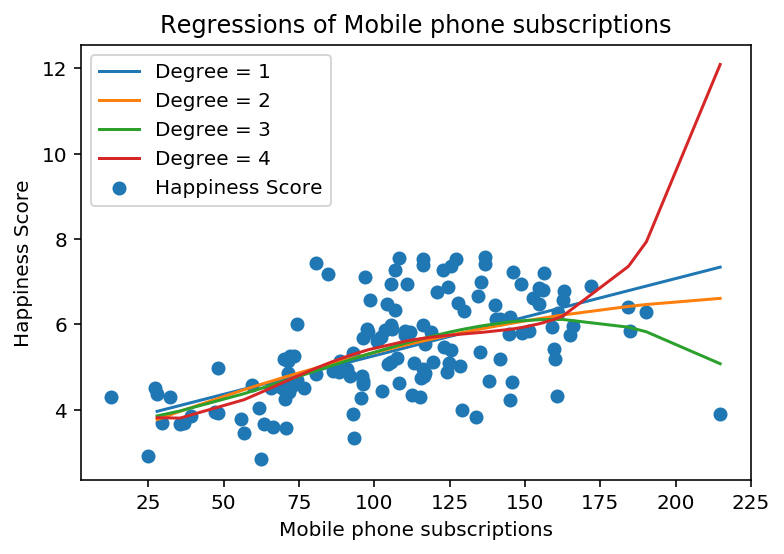

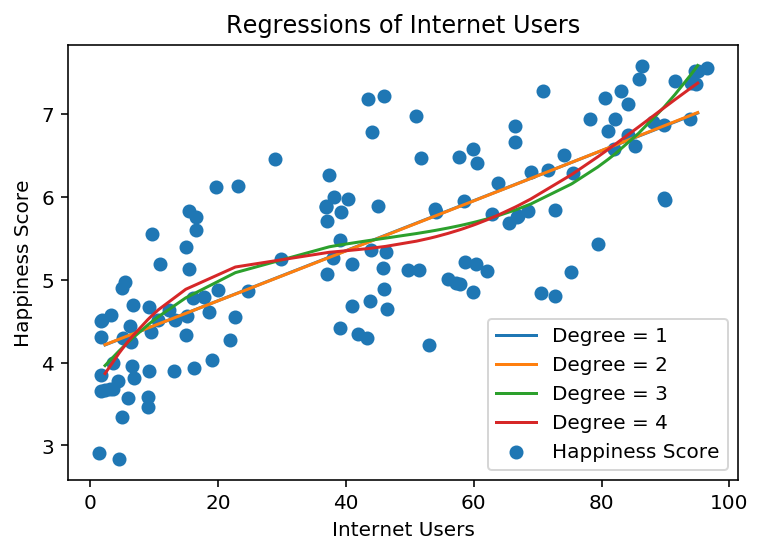

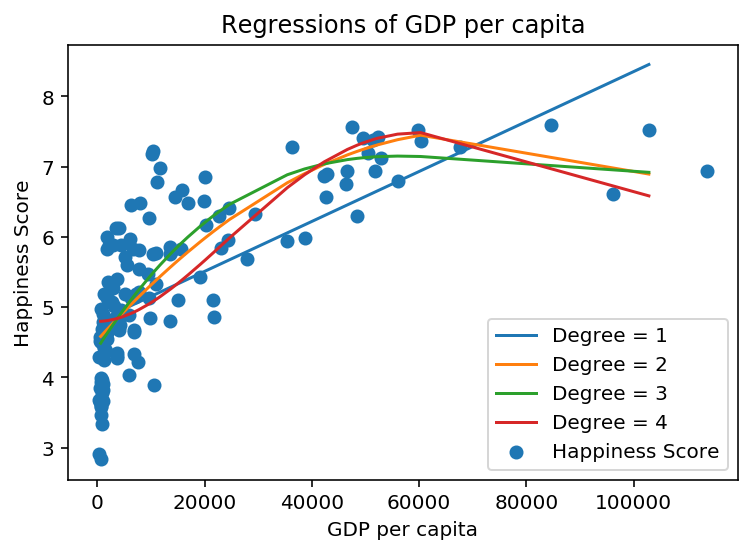

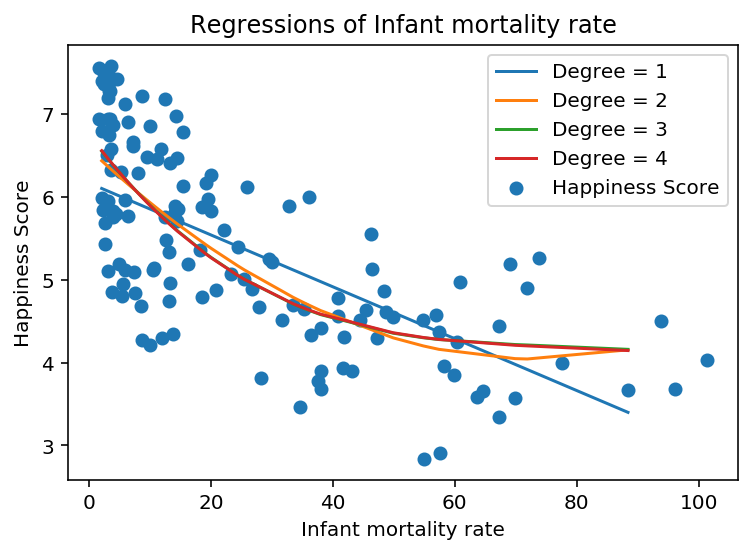

In [11]:
for feature in X.columns.values.tolist():
    X = reg_data.drop(["Happiness Score"], axis=1)
    X = X[feature]
    X = X.values.reshape(-1,1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    plt.title("Regressions of " + feature)
    plt.scatter(X, y)

    degrees = [1,2,3,4]
    for degree in degrees:
        poly_features = PolynomialFeatures(degree=degree)

        # transforms the existing features to higher degree features.
        X_train_poly = poly_features.fit_transform(X_train)

        # fit the transformed features to Linear Regression
        poly_model = LinearRegression()
        poly_model.fit(X_train_poly, y_train)

        # predicting on test data-set
        y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

        # Plotting the regression

        new_x, new_y = zip(*sorted(zip(X_test, y_test_predict)))
        plt.plot(new_x, new_y, label="Degree = " + str(degree))

    plt.xlabel(feature)
    plt.ylabel("Happiness Score")
    plt.legend()
    plt.show()
    plt.close()

These plots can show us how adjusted are the regressions with the data using only an indicator each time. Now we will try to use all the columns to predict the happiness score, but if we want to plot the regression result line we will need to perform a **PCA** to the data.

Applying PCA to our data we will obtain a single “feature” that will allow us to represent all the attribute columns in a single axis.

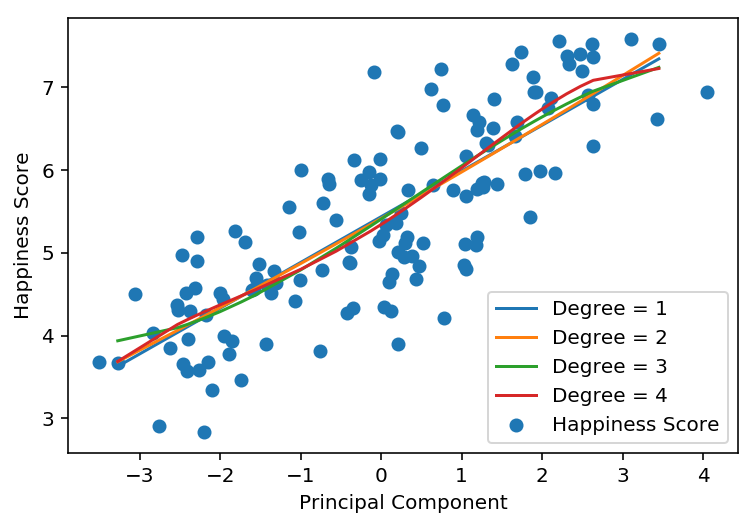

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# First we prepare the data to use a model
reg_data = data.drop(["Country Name"], axis=1)
y = reg_data["Happiness Score"]
X = reg_data.drop(["Happiness Score"], axis=1)

# Normalisation and PCA
X_norm = StandardScaler().fit_transform(X)
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_norm)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, random_state=42)

plt.scatter(X_pca, y)

degrees = [1,2,3,4]
for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree)

    # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    # Plotting the regression
    new_x, new_y = zip(*sorted(zip(X_test, y_test_predict)))
    plt.plot(new_x, new_y, label="Degree = " + str(degree))

plt.xlabel("Principal Component")
plt.ylabel("Happiness Score")
plt.legend()
plt.show()
plt.close()

## 6. Model Evaluation
To evaluate our Regression models we will calculate 2 metrics: the **Rsquare** and the **RMSE**.

### 6.1. Rsquare
The Rsquare is the proportion of the variance in the dependent variable that is predictable from the independent variable. Basically it says how good the regression function is fitting the data. The value goes between 0 and 1, being 1 the best value and 0 the worst.

### 6.2. RMSE
RMSE is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.

In [13]:
# evaluating the model on test dataset
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
r2_test = r2_score(y_test, y_test_predict)
print("RMSE test (PCA): " + str(rmse_test))
print("R2square test (PCA): " + str(r2_test))

RMSE test (PCA): 0.7401720904735556
R2square test (PCA): 0.6117332246983234


Talking about the performance of the regression models, the  R-square  of  the  showed  models  keeps  around  a  0.7 value. By looking at the distribution of the data on the previous charts,  it  can  be  observed  that  the  regression functions are fitting the data properly.

There are difficult data  distributions  for  a  regression  model  to  fit,  as  for example the one observed in the PCA chart. The more high the degree of the regression polynomial, the better fitted the data.  Nonetheless, the increase of the degree  of  the  model  can  cause  **overfitting**,  so  this  is  an aspect  that  has  to  be  treated  carefully   to  build  a  correct regression model.

# 7. Conclusions
The conclusions extracted in this post can be summarized:

* The number of Internet users is very correlated with the wealth of a country, and therefore with the happiness.
* The happiness score is highly correlated with the richness (GDP per capita) of a country.
* The poorer countries have a high infant mortality rate, fact that causes a decrease in the happiness.
* The regression functions are fitting properly the distribution of the data.
* Increasing the degree of the polynomial function can cause better results, but also the appearance of overfitting.
